Full Python Code for Training, Evaluating, and Explaining Fleet Predictive Maintenance Models.

This script demonstrates the end-to-end process of building, comparing, and
explaining machine learning models (XGBoost, Random Forest, SVM) for the
task of predictive maintenance on the Scania Trucks dataset.

It now includes an Explainable AI (XAI) section using SHAP and LIME to interpret
the best-performing model's predictions.

Dataset: APS Failure at Scania Trucks
Link: https://www.kaggle.com/datasets/uciml/aps-failure-at-scania-trucks

The primary evaluation metric is a custom cost function:
Total Cost = (Cost of a False Positive * 10) + (Cost of a False Negative * 500)

In [ ]:
#%pip install lime
#%pip install shap
#%pip install xgboost
#%pip install pytorch-tabnet

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import shap
import lime
import lime.lime_tabular
import xgboost as xgb # Corrected import
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# --- 1. Data Loading and Preprocessing ---

print("Step 1: Loading and Preprocessing Data...")

try:
    df_train = pd.read_csv('/content/aps_failure_training_set.csv', na_values='na')
    df_test = pd.read_csv('/content/aps_failure_test_set.csv', na_values='na')
except FileNotFoundError:
    print("Error: Dataset files not found.")
    print("Please download 'aps_failure_training_set.csv' and 'aps_failure_test_set.csv' from Kaggle.")
    exit()

Step 1: Loading and Preprocessing Data...


In [ ]:
#Printing dataset shape
print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

Training data shape: (60000, 171)
Test data shape: (16000, 171)


In [ ]:
def preprocess_data(df):
    """
    Preprocesses the raw dataframe by converting class labels and separating
    features from the target variable.
    """
    # Replace class labels with integers (0 for 'neg', 1 for 'pos')
    df['class'] = df['class'].replace({'neg': 0, 'pos': 1})

    # Separate features (X) and target (y)
    X = df.drop('class', axis=1)
    y = df['class']

    return X, y

X_train_raw, y_train = preprocess_data(df_train)
X_test_raw, y_test = preprocess_data(df_test)

In [ ]:
# Impute missing values using the median from the training set to avoid data leakage
print("Imputing missing values with median...")
# Using a dictionary to store medians for each column
medians = X_train_raw.median()
X_train = X_train_raw.fillna(medians)
X_test = X_test_raw.fillna(medians)

print("Data preprocessing complete.")
print("-" * 50)

Imputing missing values with median...
Data preprocessing complete.
--------------------------------------------------


In [ ]:
# --- 2. Model Training and Evaluation ---

# Dictionary to store results for comparison
results = {}

def evaluate_model(model_name, y_true, y_pred, y_pred_proba):
    """
    Calculates performance metrics and returns them in a dictionary.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10 * fp + 500 * fn
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)

    print(f"Results for {model_name}:")
    print(f"  - Total Cost: ${cost:,}")
    print(f"  - ROC-AUC Score: {roc_auc:.4f}")
    print(f"  - F1 Score: {f1:.4f}")
    print(f"  - Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

    return {
        'Cost': cost,
        'ROC-AUC': roc_auc,
        'F1 Score': f1,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }

In [ ]:
# --- Model A: XGBoost Classifier ---
print("\nStep 2a: Training XGBoost Classifier...")

# Calculate the weight to handle severe class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    seed=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_pred_proba > 0.5).astype(int)

# Evaluate and store results
results['XGBoost'] = evaluate_model('XGBoost', y_test, xgb_pred, xgb_pred_proba)
print("-" * 50)


Step 2a: Training XGBoost Classifier...
Results for XGBoost:
  - Total Cost: $29,970
  - ROC-AUC Score: 0.9941
  - F1 Score: 0.8564
  - Confusion Matrix: TP=316, TN=15578, FP=47, FN=59
--------------------------------------------------


In [ ]:
# --- Model B: Random Forest Classifier ---
print("\nStep 2b: Training Random Forest Classifier...")

rf_model = RandomForestClassifier(
    n_estimators=150,       # A reasonable number of trees
    class_weight='balanced',# Handles imbalance
    random_state=42,
    n_jobs=-1               # Use all available cores
)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_pred = (rf_pred_proba > 0.5).astype(int)

# Evaluate and store results
results['Random Forest'] = evaluate_model('Random Forest', y_test, rf_pred, rf_pred_proba)
print("-" * 50)


Step 2b: Training Random Forest Classifier...
Results for Random Forest:
  - Total Cost: $79,170
  - ROC-AUC Score: 0.9932
  - F1 Score: 0.7126
  - Confusion Matrix: TP=217, TN=15608, FP=17, FN=158
--------------------------------------------------


In [ ]:
# --- Model C: TabNet Classifier ---
print("\nStep 2c: Training TabNet Classifier...")

tabnet_model = TabNetClassifier(
    verbose=0,
    seed=42
)

# Fit model (TabNet expects numpy arrays of type float32/int)
tabnet_model.fit(
    X_train.values.astype(np.float32),
    y_train.values.astype(int),
    max_epochs=10,
    patience=3
)

# Make predictions
tabnet_pred_proba = tabnet_model.predict_proba(X_test.values.astype(np.float32))[:, 1]
tabnet_pred = (tabnet_pred_proba > 0.5).astype(int)

# Evaluate and store results
results['TabNet'] = evaluate_model('TabNet', y_test, tabnet_pred, tabnet_pred_proba)
print("-" * 50)



Step 2c: Training TabNet Classifier...
Results for TabNet:
  - Total Cost: $139,960
  - ROC-AUC Score: 0.9779
  - F1 Score: 0.3714
  - Confusion Matrix: TP=96, TN=15579, FP=46, FN=279
--------------------------------------------------



Step 3: Explaining the XGBoost Model...
(This section will generate and show several plots)
  - Generating SHAP Global Feature Importance plot...


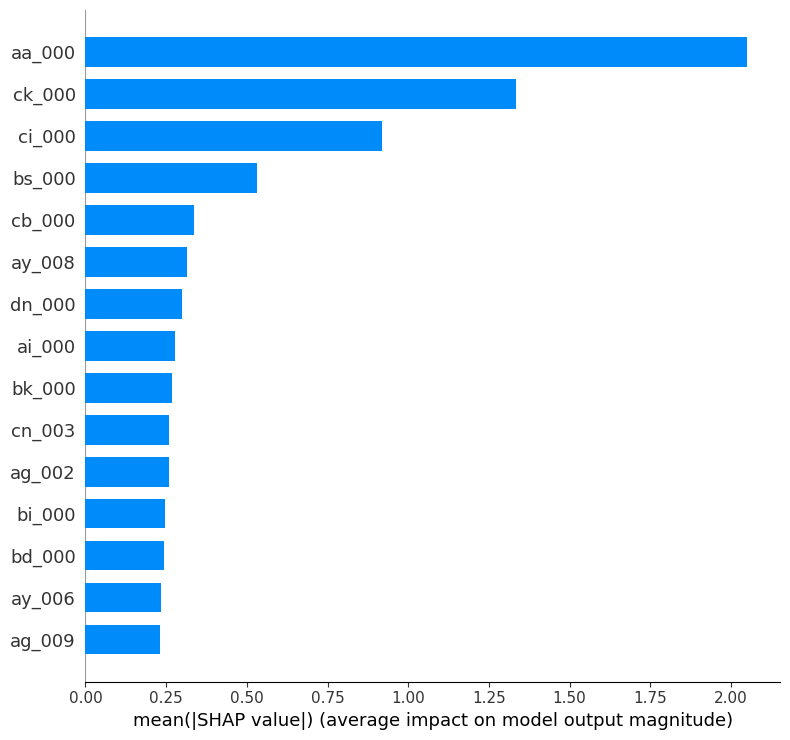

  - Generating LIME and SHAP local explanations for a high-risk case...


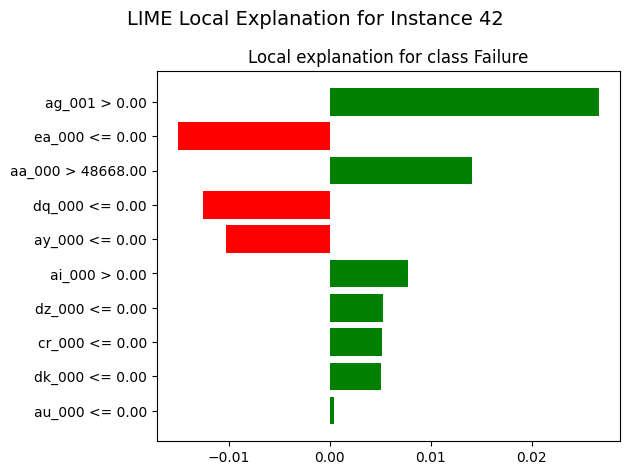

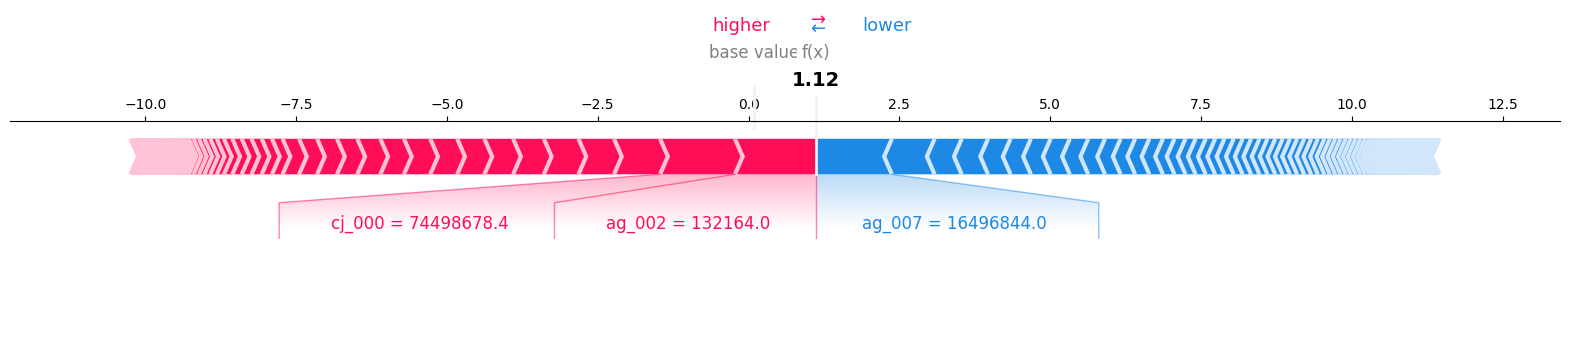

    (Close the SHAP force plot window to continue)
--------------------------------------------------


In [ ]:
# --- 3. Explainable AI (XAI) with SHAP and LIME ---
print("\nStep 3: Explaining the XGBoost Model...")
print("(This section will generate and show several plots)")

# A. Global Explanation with SHAP
print("  - Generating SHAP Global Feature Importance plot...")
explainer_shap = shap.TreeExplainer(xgb_model)
shap_values = explainer_shap.shap_values(X_test)

# Plot SHAP summary plot (bar chart version)
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, show=True)
# The plot will be displayed. The title is automatically generated by SHAP.

# B. Local Explanation Case Study (for a single high-risk prediction)
print("  - Generating LIME and SHAP local explanations for a high-risk case...")

# Find a true positive prediction to explain (a correctly identified failure)
true_positives_indices = X_test[(y_test == 1) & (xgb_pred == 1)].index

if not true_positives_indices.empty:
    instance_idx = true_positives_indices[0]
    instance_to_explain = X_test.loc[instance_idx]

    # LIME Explanation
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=['No Failure', 'Failure'],
        mode='classification'
    )
    explanation_lime = explainer_lime.explain_instance(
        instance_to_explain.values,
        xgb_model.predict_proba,
        num_features=10
    )

    # Plot LIME explanation
    fig = explanation_lime.as_pyplot_figure()
    fig.suptitle(f'LIME Local Explanation for Instance {instance_idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

    # SHAP Force Plot for the same instance
    # Note: The JS version of the force plot is more interactive in notebooks
    shap.force_plot(
        explainer_shap.expected_value,
        shap_values[instance_idx, :],
        X_test.iloc[instance_idx, :],
        matplotlib=True,
        show=True
    )
    print("    (Close the SHAP force plot window to continue)")

else:
    print("  - No true positive instances found in the test set to explain.")

print("-" * 50)



Step 4: Final Model Comparison...

--- Overall Performance Summary (Sorted by Cost) ---
                   Cost   ROC-AUC  F1 Score     FN    FP     TP       TN
XGBoost         29970.0  0.994148  0.856369   59.0  47.0  316.0  15578.0
Random Forest   79170.0  0.993190  0.712644  158.0  17.0  217.0  15608.0
TabNet         139960.0  0.977901  0.371373  279.0  46.0   96.0  15579.0


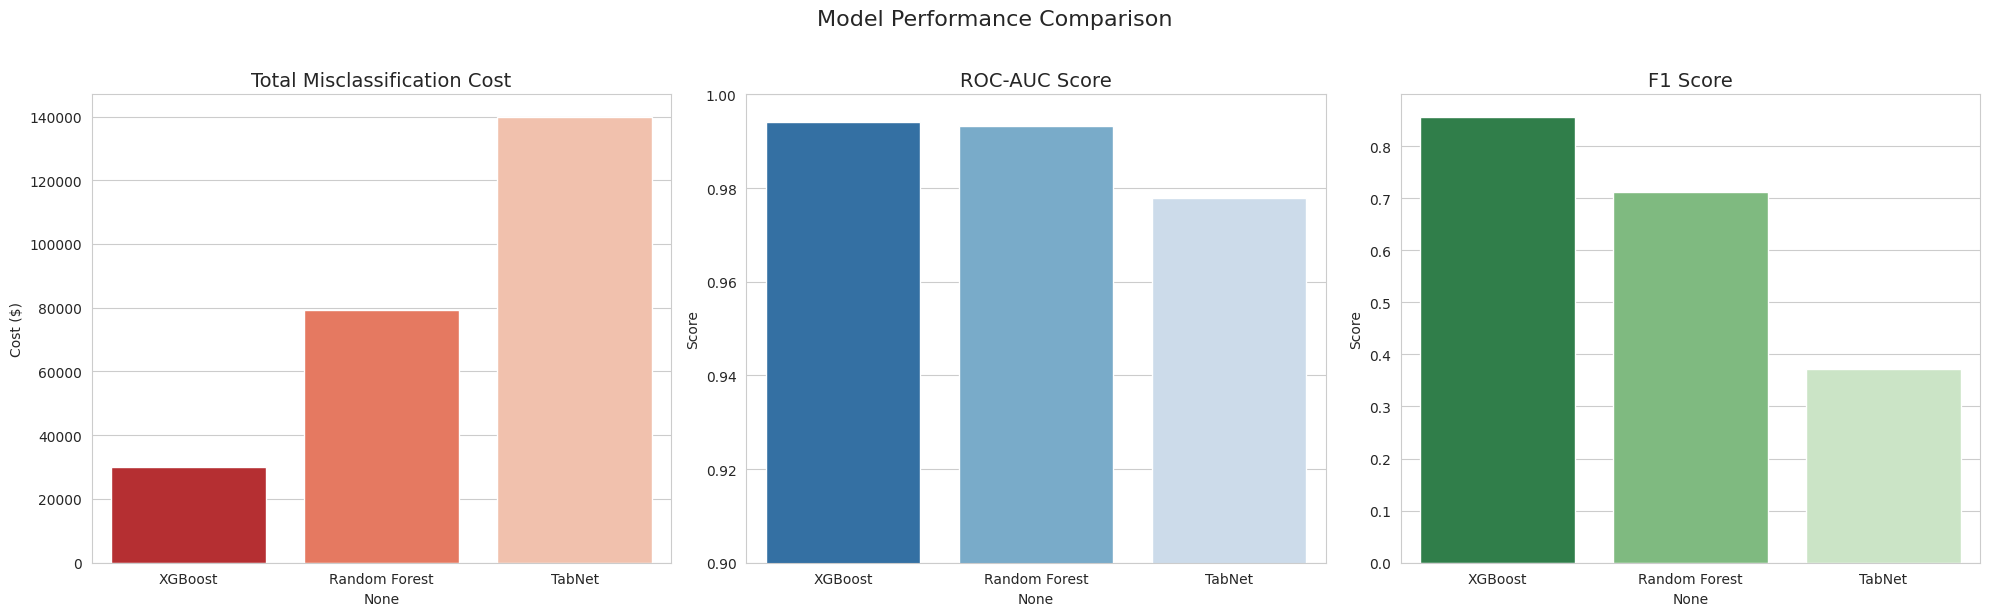

In [31]:
# --- 4. Final Comparison ---
print("\nStep 4: Final Model Comparison...")

# Create a DataFrame from the results dictionary for easy viewing
results_df = pd.DataFrame(results).T
results_df = results_df[['Cost', 'ROC-AUC', 'F1 Score', 'FN', 'FP', 'TP', 'TN']]

# Sort by the primary metric: Cost
results_df.sort_values('Cost', ascending=True, inplace=True)

print("\n--- Overall Performance Summary (Sorted by Cost) ---")
print(results_df)

# Visualize the results
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.set_style("whitegrid")

# Bar plot for Cost
sns.barplot(x=results_df.index, y='Cost', data=results_df, ax=ax[0], palette='Reds_r')
ax[0].set_title('Total Misclassification Cost', fontsize=14)
ax[0].set_ylabel('Cost ($)')

# Bar plot for ROC-AUC
sns.barplot(x=results_df.index, y='ROC-AUC', data=results_df, ax=ax[1], palette='Blues_r')
ax[1].set_title('ROC-AUC Score', fontsize=14)
ax[1].set_ylabel('Score')
ax[1].set_ylim(0.9, 1.0) # Zoom in on the relevant range

# Bar plot for F1 Score
sns.barplot(x=results_df.index, y='F1 Score', data=results_df, ax=ax[2], palette='Greens_r')
ax[2].set_title('F1 Score', fontsize=14)
ax[2].set_ylabel('Score')

plt.suptitle('Model Performance Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()